In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import cv2
from mpl_toolkits.mplot3d import Axes3D
from func_util_geom import func_plot_cameras, func_set_axes_equal, func_reproject, func_quat2dcm, func_dcm2quat



In [2]:
# Camera coordinate system: looks down positive Z-direction, left-handed. 
upvector = np.array([0,1,0], dtype=float) # Gravity vector, aka horizon plane normal

# Generate points on greater circle
nopt = 50
circlept = np.array([(np.sin(x*2*np.pi/nopt),np.cos(x*2*np.pi/nopt)) for x in xrange(nopt)])
circlept = np.concatenate((circlept[:,[0]], np.zeros((nopt,1)), circlept[:,[1]]), axis=1) 

In [3]:
imgwidth = 1920
imgheight = 1080
wh = np.array([imgwidth, imgheight], dtype=float)

# Camera calibration
fc = np.array([ 1140.562942559317435, 1147.926087601573499 ])
cc = np.array([ 965.798150992612591 , 525.928730340185098 ]) - wh/2
kc = np.array([ -0.260164631998344 , 0.072587065880871 , 0.000650296041099 , -0.000411644825172 , 0.000000000000000 ])

1.0
[[ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]]


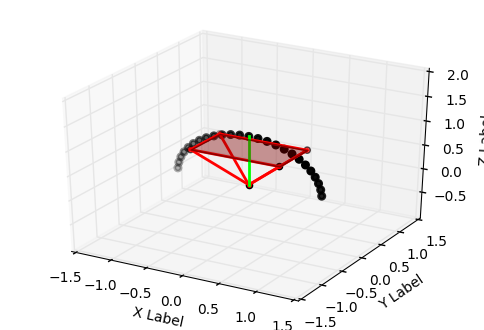

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

R = np.identity(3)
#a = np.random.rand(3)
#a = a / np.linalg.norm(a)
#b = np.cross(a, np.random.rand(3))
#b = b / np.linalg.norm(b)
#c = np.cross(a,b)
#R =  np.stack((a,b,c))

print np.linalg.det(R)
print R

ptpositive = np.where(np.sum(circlept*R[2,:], axis=1)>0)[0]

t = np.array([0,0,0], dtype=float)
func_plot_cameras(ax, fc, cc,wh,R,-np.dot(R.transpose(), t        ),rgbface=np.array([1.0, 0.0, 0.0]),camerascaling=1.0,lw=2.0)
#ax.scatter(ptnorm[best_inliers[0:-1:subsampleno],0], ptnorm[best_inliers[0:-1:subsampleno],1], ptnorm[best_inliers[0:-1:subsampleno],2], color=np.array([0.0, 0.0, 1.0]), linewidth=2.0)
#ax.scatter(circlept[:,0], circlept[:,1], circlept[:,2], color=np.array([0.0, 0.0, 1.0]), linewidth=2.0)
ax.scatter(circlept[ptpositive,0], circlept[ptpositive,1], circlept[ptpositive,2], color=np.array([0.0, 0.0, 0.0]), linewidth=2.0)

#ax.plot([0, R[0,0]], [0, R[0,1]], [0, R[0,2]], color=np.array([0.0, 1.0, 0.0]), linewidth=2.0)
#ax.plot([0, R[1,0]], [0, R[1,1]], [0, R[1,2]], color=np.array([0.0, 1.0, 0.0]), linewidth=2.0)
ax.plot([0, R[2,0]], [0, R[2,1]], [0, R[2,2]], color=np.array([0.0, 1.0, 0.0]), linewidth=2.0)
func_set_axes_equal(ax)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()
#plt.close('all')

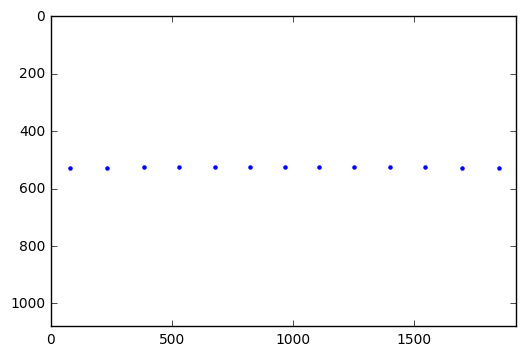

In [5]:
# Reprojection test
circlept_re = func_reproject(circlept[ptpositive,:], R, -np.dot(R.transpose(),t), fc, cc+wh/2.0, kc, camcenter=0)

# NOTE: Reprojects also points behind camera. I.e. doubles horizon line!
fig = plt.figure()
plt.scatter(circlept_re[:,0], circlept_re[:,1], 5, color='blue')
plt.axis([0, imgwidth, imgheight, 0])
plt.show()
    

In [ ]:
Initialize all cameras at identity
find absolute pose 
add smoothness constraint between frames (sum of cosine similarities between unit quarternions)
reprojected horizon points have to lie on max gradient (prepare gradient images?)
(IDEA: instead of gradient, use line of pixels above and below reprojected point, 
 orthogonal to current horizon, use grad descent on this )
next step: add OF particles

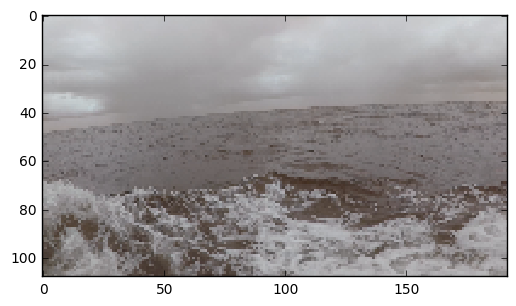

float64
351.552272073


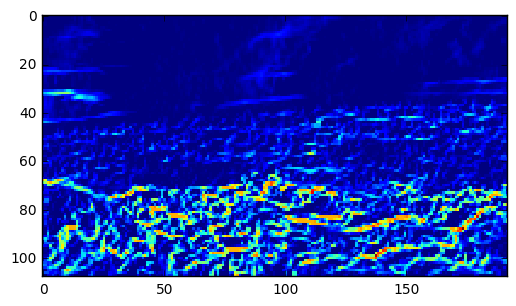

In [20]:
# Load image, get gradient magnitude, smoothen and downscale
imtest = '/home/kroegert/local/Datasets/GoProWave/GOPR3890/0001.png'
imgtmp = cv2.imread(imtest)
imgtmp = cv2.resize(imgtmp, (int(wh[0])/1, int(wh[1])/1))

plt.figure()
plt.imshow(imgtmp, interpolation='nearest')
plt.show()

imgtmp = cv2.cvtColor(imgtmp,cv2.COLOR_BGR2GRAY)

res_dy = cv2.Sobel(imgtmp, 0, 0, 1).astype(float).astype(float)
res_dx = cv2.Sobel(imgtmp, 0, 1, 0).astype(float).astype(float)

#res_dy = np.pad(imgtmp[0:-1,:]-imgtmp[1::,:], [(0,1),(0,0)], 'edge')
#res_dx = np.pad(imgtmp[:,0:-1]-imgtmp[:,1::], [(0,0),(0,1)], 'edge')


res = np.sqrt(res_dx**2 + res_dy**2)
#res = np.sqrt(np.abs(res_dx))

print res.dtype
print np.max(res)
res = ((res / np.max(res))*255).astype(np.uint8)
#cv::Sobel( img_ao_fmat_pyr[i], img_ao_dx_fmat_pyr[i], CV_32F, 1, 0, 1, 1, 0, cv::BORDER_DEFAULT );

plt.figure()
plt.imshow(res, interpolation='nearest')
plt.show()


Loss,  476.738461538


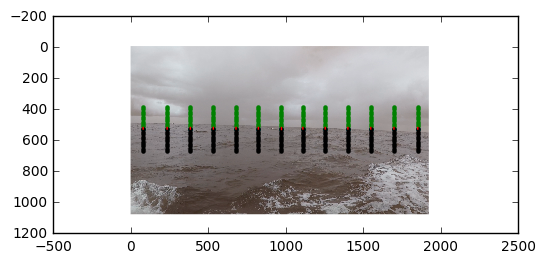

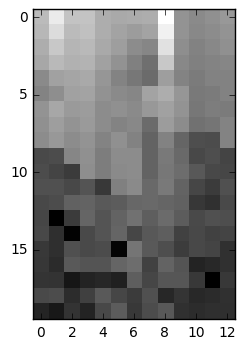

In [25]:
# For each reprojected point get vector orthogonal to horizon line, 
# get list of pixel values along this line.

# define sample points orthogonal to horizon line
nopt = 10 # of both sides of horizon
#sptdist = np.exp(np.linspace(0,np.log(np.sqrt(imgwidth*imgheight)/3),nopt)) # logarithmic scaling
sptdist = np.linspace(1,np.sqrt(imgwidth*imgheight)/10,nopt)
padval = np.max(sptdist).astype(int)
#padval=0

# load and pad image
imtest = '/home/kroegert/local/Datasets/GoProWave/GOPR3890/2001.png'
imgtmp = cv2.imread(imtest)
imgtmp_pad = cv2.cvtColor(imgtmp,cv2.COLOR_BGR2GRAY)
imgtmp_pad = np.pad(imgtmp_pad, [(padval,padval),(padval,padval)], 'edge')


# reproject points and get horizon orthogonal vectors for each point 
def projectcirclepts(R_in):
    ptpositive = np.where(np.sum(circlept*R_in[2,:], axis=1)>0)[0]
    circlept_re = func_reproject(circlept[ptpositive,:], R_in, -np.dot(R_in.transpose(),t), fc, cc+wh/2.0, kc, camcenter=0)

    ptvisible =  ((circlept_re[:,0] > 0) & (circlept_re[:,0] < imgwidth) & 
                  (circlept_re[:,1] > 0) & (circlept_re[:,1] < imgheight))

    circlept_re_tmp = np.concatenate((circlept_re[[-1],:], circlept_re, circlept_re[[0],:]), axis=0)
    hvec = circlept_re_tmp[2:,:] - circlept_re_tmp[:-2,:]
    hvec /= np.linalg.norm(hvec, axis=1)[:,None] 
    hvec = np.vstack((hvec[:,1], -hvec[:,0])).T
    
    return circlept_re, ptpositive, ptvisible, hvec

def ptsamplebilin(pt, img):
    ptint = pt.astype(int)
    rem = pt - ptint
     
    w1 = (1-rem[:,1])*(1-rem[:,0])
    w2 = (  rem[:,1])*(  rem[:,0])
    w3 = (1-rem[:,1])*(  rem[:,0])
    w4 = (  rem[:,1])*(1-rem[:,0])
    
    return ((img[ptint[:,1]  , ptint[:,0]  ] * w1) + 
            (img[ptint[:,1]+1, ptint[:,0]+1] * w2) + 
            (img[ptint[:,1]  , ptint[:,0]+1] * w3) + 
            (img[ptint[:,1]+1, ptint[:,0]  ] * w4))
    
    
def samplepts(R_in):
    circlept_re, ptpositive, ptvisible, hvec = projectcirclepts(R_in)
    
    # sample pixels orthogonal to horizon line
    idxreproj = np.where(ptvisible)[0]
    testimg = np.zeros((2*nopt,idxreproj.shape[0]), dtype=np.int)
    
    pt_up_l = []
    pt_dw_l = []    

    for j,i in zip(xrange(idxreproj.shape[0]),idxreproj):
        #if (ptvisible[i]):
        stmp = hvec[i,:,None] * sptdist[None,:]

        pt_up = (circlept_re[i,:,None] + stmp).T
        pt_dw = (circlept_re[i,:,None] - stmp).T        
        
        #pt_up = (pt_up + 0.5).astype(int) # round and cast as int
        #pt_dw = (pt_dw + 0.5).astype(int)
        
        pt_up_l.append(pt_up)
        pt_dw_l.append(pt_dw)

        #plt.scatter(pt_up[:,0], pt_up[:,1], 10, color='green')
        #plt.scatter(pt_dw[:,0], pt_dw[:,1], 5, color='black')

        # TODO: Bilinear pixel sampling
        testimg[0:nopt,j] = ptsamplebilin(pt_up+padval, imgtmp_pad)[::-1]
        testimg[nopt:,j] = ptsamplebilin(pt_dw+padval, imgtmp_pad)
        
        #testimg[0:nopt,j] = imgtmp_pad[pt_up[:,1]+padval, pt_up[:,0]+padval][::-1]
        #testimg[nopt:,j] = imgtmp_pad[pt_dw[:,1]+padval, pt_dw[:,0]+padval]

        #print (np.mean(imgtmp_pad[pt_up[:,1]+padval, pt_up[:,0]+padval]), 
        #       np.mean(imgtmp_pad[pt_dw[:,1]+padval, pt_dw[:,0]+padval]))
    
    return testimg, pt_up_l, pt_dw_l

def eval_loss(Rquat_in):
    R_in = func_quat2dcm(Rquat_in)
    
    testimg = samplepts(R_in)[0]
    
    #totalvar = np.var(testimg)
    #var_up = np.var(testimg[0:nopt,:])
    #var_dw = np.var(testimg[nopt:,:])
    
    #return np.minimum(var_up, var_dw)
    #return var_up + var_dw
    
    return 512-np.abs(np.mean(testimg[0:nopt,:])-np.mean(testimg[nopt:,:]))
    
    


Rnew = np.identity(3)
#a = np.random.rand(3)
#a = a / np.linalg.norm(a)
#b = np.cross(a, np.random.rand(3))
#b = b / np.linalg.norm(b)
#c = np.cross(a,b)
#Rnew =  np.stack((a,b,c))


circlept_re, ptpositive, ptvisible, hvec = projectcirclepts(Rnew)

testimg, pt_up_l, pt_dw_l = samplepts(Rnew)

# display image
plt.figure()
plt.imshow(imgtmp, interpolation='nearest')
plt.hold(True)
plt.scatter(circlept_re[ptvisible,0], circlept_re[ptvisible,1], 5, color='blue')
plt.plot((circlept_re[ptvisible,0], circlept_re[ptvisible,0] + hvec[ptvisible,0]*10), (circlept_re[ptvisible,1], circlept_re[ptvisible,1] + hvec[ptvisible,1]*10),  color='red')
for pt in pt_up_l:
    plt.scatter(pt[:,0], pt[:,1], 5, color='green')
for pt in pt_dw_l:
    plt.scatter(pt[:,0], pt[:,1], 5, color='black')

print "Loss, ", eval_loss(func_dcm2quat(Rnew))
        
#plt.axis([0, imgwidth, imgheight, 0])
plt.show()
plt.figure()
plt.imshow(testimg, interpolation='nearest', cmap='gray')
plt.show()

476.738461538
Optimization terminated successfully.
         Current function value: 476.446154
         Iterations: 121
         Function evaluations: 356
[  9.99999927e-01   8.32585149e-05   1.40285955e-04   3.44318978e-04]


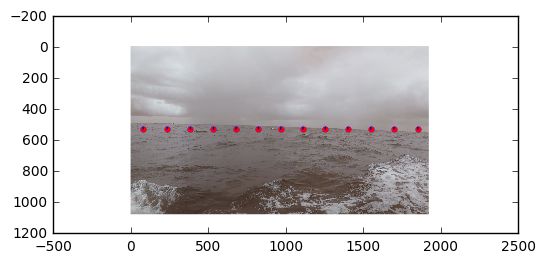

In [26]:
 
#a = np.random.rand(3)blue
#a = a / np.linalg.norm(a)
#b = np.cross(a, np.random.rand(3))
#b = b / np.linalg.norm(b)
#c = np.cross(a,b)
#Rnew =  np.stack((a,b,c))    
Rnew = np.identity(3)
    
x0 = func_dcm2quat(Rnew)

#[x, f, d] = scipy.optimize.fmin_l_bfgs_b(eval_loss, x0, maxfun=40)

#def eval_loss2(xin):    
#    return np.linalg.norm(func_dcm2quat(np.identity(3))-xin)
    
print eval_loss(x0)
    
#x = scipy.optimize.fmin_bfgs(eval_loss, x0)
#x = scipy.optimize.fmin_slsqp(eval_loss, x0)
#x = scipy.optimize.fmin_ncg(eval_loss, x0)
x = scipy.optimize.fmin(eval_loss, x0)


#scipy.optimize.fmin_powell


print x


# display image
plt.figure()
plt.imshow(imgtmp, interpolation='nearest')
plt.hold(True)

circlept_re, ptpositive, ptvisible, hvec = projectcirclepts(func_quat2dcm(x))
plt.scatter(circlept_re[ptvisible,0], circlept_re[ptvisible,1], 10, color='blue')
plt.plot((circlept_re[ptvisible,0], circlept_re[ptvisible,0] + hvec[ptvisible,0]*10), (circlept_re[ptvisible,1], circlept_re[ptvisible,1] + hvec[ptvisible,1]*10),  color='blue')

circlept_re, ptpositive, ptvisible, hvec = projectcirclepts(func_quat2dcm(x0))
plt.scatter(circlept_re[ptvisible,0], circlept_re[ptvisible,1], 10, color='red')


#plt.axis([0, imgwidth, imgheight, 0])
plt.show()
